# Adding Libs

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from   networkx.algorithms import community
import scipy.io
import pandas as pd
import random
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.mixture import GaussianMixture

## Initialization

In [2]:
connectomes = []

# Loading Data

In [3]:
files_path = "./Autism_rsfmri/"
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(files_path) if isfile(join(files_path, f)) and f.find('connectivity_matrix')>=0]

In [4]:
fn = "ASD67B_rsfMRI_region_names_full_file.txt"
region_names_full = []
with open(join(files_path, fn), 'r') as f:        
    region_names_full = [line for line in f]

fn = "ASD67B_rsfMRI_region_names_abbrev_file.txt"
region_names_abbrev = []
with open(join(files_path, fn), 'r') as f:        
    region_names_abbrev = [line for line in f]
    
def del_inf(conn_matrix):
    for i in range(len(conn_matrix)):
        conn_matrix[i][i] = 0        

In [5]:
for file_name in onlyfiles:
    fn = file_name[0:file_name.find('_rsfMRI_connectivity_matrix_file')]

       
    with open(join(files_path, file_name), 'r') as f:
        
        conn_matrix = [[float(num) for num in line.split()] for line in f]
        
    del_inf(conn_matrix)
        
    tmp_dict = {
        "type": "ASD" if fn.find('ASD')>=0 else "TD",
        "name": fn[3:] if fn.find('ASD')>=0 else fn[2:],
        "conn_matrix": np.array(conn_matrix),
    }
    
    connectomes.append(tmp_dict)

# Functions for Feature Extraction 

In [6]:
def get_all_node_strength(conn):
    
    A = nx.to_numpy_array(conn["graph"])
    G = np.multiply(A,conn["conn_matrix"])
    out = np.sum(G, axis=0)
    m = np.mean(out)
    v = np.var(out)
    out = (out-m)/v
    return np.array(out)


def get_all_eccentricity(conn):

    ecc = nx.algorithms.distance_measures.eccentricity(conn["graph"])
    out = np.array(list(ecc.values()))
    out = out/(conn["conn_matrix"].shape[0]-1)  
    return np.array(out)


def get_all_triangles(conn):
    
    out = np.array(list(nx.triangles(conn["graph"]).values()))
    n = conn["conn_matrix"].shape[0]
    out = out/((n-1)*(n-2)/2)
    return np.array(out)


def get_all_clustring(conn):
    
    out = np.array(list(nx.clustering(conn["graph"]).values()))    
    return np.array(out)

    
def get_all_degree_centrality(conn):
    
    out = np.array(list(nx.algorithms.centrality.degree_centrality(conn["graph"]).values()))    
    return np.array(out)


def get_all_closeness_centrality(conn):
    
    out = np.array(list(nx.algorithms.centrality.closeness_centrality(conn["graph"]).values()))   
    return np.array(out)


def get_all_betweenness_centrality(conn):
    
    out = np.array(list(nx.algorithms.centrality.betweenness_centrality(conn["graph"]).values())) 
    return np.array(out)


def get_all_eigenvector_centrality(conn):
    
    out = nx.algorithms.centrality.eigenvector_centrality(conn["graph"])
    out = np.array(list(out.values()))  
    return np.array(out)

In [7]:
def get_max_and_min(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3-q1
    maximum = np.max(data[(data <= (q3 + 1.5*iqr))])
    minimum = np.min(data[(data >= (q1 - 1.5*iqr))])
    return {'rmax':np.max(data),'rmin':np.min(data),'emax':q3,'emin':q1}


def get_summerized(data):
    
    out = data
    mm = get_max_and_min(out)    
    return np.array([mm['rmax'], mm['emax'], np.median(out), np.mean(out), mm['emin'], mm['rmin']])


def get_modularity(conn):
    communities_generator = community.girvan_newman(conn["graph"])
    top_level_communities = next(communities_generator)
    next_level_communities = next(communities_generator)
    comm = sorted(map(sorted, next_level_communities))
    
    return np.array(nx.algorithms.community.modularity(conn["graph"],comm))


def get_global_efficiency(conn):
    out = nx.algorithms.efficiency_measures.global_efficiency(conn["graph"])    
    return np.array(out)


def get_total_triangles(conn):
    
    out = conn["all_triangles"]
    n = conn["conn_matrix"].shape[0]
    out = np.sum(out)/(n*(n-1)*(n-2)/18)     
    return np.array(out)

# Extracting feature for each

In [8]:
j = 0.4
i = 0

for conn in connectomes:
    j = 0.35
    mat35 = (conn["conn_matrix"] >= j)*1 + (conn["conn_matrix"] <= -j)*1
    j = 0.4 
    mat4 = (conn["conn_matrix"] >= j)*1 + (conn["conn_matrix"] <= -j)*1
    conn["graph"]         = nx.from_numpy_matrix(mat35 - mat4)
    conn["all_node_strength"] = get_all_node_strength(conn)
    conn["all_eccentricity"]  = get_all_eccentricity(conn)
    conn["all_triangles"]     = get_all_triangles(conn)
    conn["all_clustring"]     = get_all_clustring(conn)
    conn["all_bet_cent"]      = get_all_betweenness_centrality(conn)
    conn["all_close_cent"]    = get_all_closeness_centrality(conn)
    conn["all_deg_cent"]      = get_all_degree_centrality(conn)
    conn["all_eig_cent"]      = get_all_eigenvector_centrality(conn)


In [9]:
i = 0

for conn in connectomes:
    conn["node_strength"] = get_summerized(conn["all_node_strength"])
    conn["eccentricity"]  = get_summerized(conn["all_eccentricity"])
    conn["triangles"]     = get_summerized(conn["all_triangles"])
    conn["clustring"]     = get_summerized(conn["all_clustring"])
    conn["bet_cent"]      = get_summerized(conn["all_bet_cent"])
    conn["close_cent"]    = get_summerized(conn["all_close_cent"])
    conn["deg_cent"]      = get_summerized(conn["all_deg_cent"])
    conn["eig_cent"]      = get_summerized(conn["all_eig_cent"])
    conn["glob_eff"]      = get_global_efficiency(conn)
    conn["modularity"]      = get_global_efficiency(conn)

In [11]:
#with open('modularity0-4.npy', 'rb') as f:
#    for conn in connectomes :
#        conn["modularity"] = np.load(f)

# Selecting best features

In [49]:
all_feat = []
feats_name = ["node_strength", "eccentricity", "triangles", "clustring", "bet_cent" \
             , "close_cent", "deg_cent"]

for conn in connectomes:
    temp = []
    for feat_n in feats_name:
        temp.append(conn[feat_n].tolist())
        
    temp = np.array(temp)
    temp = np.append(temp, conn["modularity"])
    temp = np.append(temp, conn["glob_eff"])
    temp = temp.flatten()
    
    temp = temp[[13,14,15,16,20,24,27,31,32,33,34,37,38,39,42,43]]#8,12
    all_feat.append(temp)   
    
features = np.array(all_feat)

# ----------------------------------------------------------------------------------------------------

# Real Labels

In [32]:
tlabels = []
for conn in connectomes:
    tlabels.append(conn["type"])
tlabels0 = (np.array(tlabels)!='ASD')*1
tlabels1 = (np.array(tlabels)=='ASD')*1
tlabels = (np.array(tlabels)!='ASD')*1

# Clustering

### Agglomerative Clustering

In [66]:
ncl = 3
summ = 0

from sklearn.cluster import  AgglomerativeClustering
aggl = AgglomerativeClustering(n_clusters=ncl).fit(all_feat) #‘ward’, ‘complete’, ‘average’, ‘single’}
alabels = aggl.labels_

for i in range(ncl):
    s = np.sum(((alabels==i)*1*tlabels0)) # normal people
    ns = np.sum(((alabels==i)*1*tlabels1)) # autistic people
    print(s, ns, s/(s+ns), ns/(s+ns), abs(s-ns)/(s+ns))
    summ += abs(s-ns)/(s+ns)
summ/ncl
    

10 21 0.3225806451612903 0.6774193548387096 0.3548387096774194
13 7 0.65 0.35 0.3
14 14 0.5 0.5 0.0


0.2182795698924731

### Gaussian Mixture

In [104]:
ncl = 2
summ = 0

from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=ncl, random_state=0).fit(all_feat)

glabels = gm.predict(all_feat)

for i in range(ncl):
    s = np.sum(((glabels==i)*1*tlabels0))
    ns = np.sum(((glabels==i)*1*tlabels1))
    print(s, ns, s/(s+ns), ns/(s+ns), abs(s-ns)/(s+ns))
    summ += abs(s-ns)/(s+ns)
summ/ncl
    


24 19 0.5581395348837209 0.4418604651162791 0.11627906976744186
13 23 0.3611111111111111 0.6388888888888888 0.2777777777777778


0.19702842377260982

C:\Users\Ideal\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


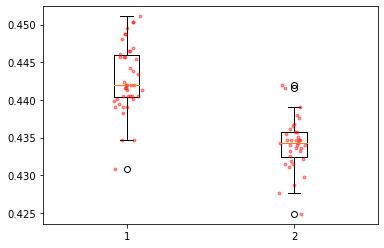

In [108]:
import matplotlib.pyplot as plt

plt.figure()
labels = glabels
fea = features[:,8]

datas_for_plotting = [[] for i in range(max(labels)+1)]

for i in range(79):
    conn = connectomes[i]
    datas_for_plotting[labels[i]].append(fea[i])

bp = plt.boxplot(datas_for_plotting)

for i in range(max(labels)+1):
    y = datas_for_plotting[i]
    x = np.random.normal(1+i, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.4)


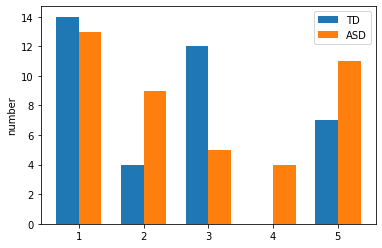

In [94]:


N = ncl
TD = (14,4,12,0,7)
ASD = (13,9,5,4,11)

#[72,55,65,6]
#[80,54,71,59]

#[68,62,59]
#[75,66,56]

#[61,61]
#[65,62]



ind = np.arange(N) 
width = 0.35       
plt.bar(ind, TD, width, label='TD')
plt.bar(ind + width, ASD, width,
    label='ASD')

plt.ylabel('number')

# Good features | p-value threshold=0.05

plt.xticks(ind + width / 2, ('1', '2', '3','4','5'))
plt.legend(loc='best')
plt.show()

### box plot of  a feature

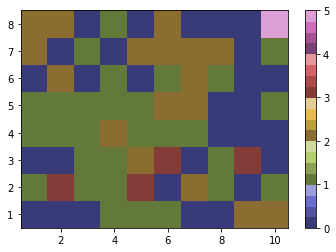

In [70]:
mat = (glabels)*1
mat = np.append(mat,5)
mat = mat.reshape(8,10)


#fig = plt.figure(figsize=(8,10))
x = np.arange(0.5, 10+1, 1)  
y = np.arange(0.5, 8+1, 1)  

plt.pcolormesh(x,y,mat,cmap="tab20b")
plt.colorbar()
plt.clim(0, 5)

# -------------------------------------------------------------------------------------------------------

# ANOVA

In [56]:
fea_num = features.shape[1]


for j in range(fea_num):
    print(j)
    fea = features[:,j]
    people_frame = pd.DataFrame({"type" : glabels})
    groups = people_frame.groupby("type").groups
    g = []

    for i in range(2):
        g.append(fea[groups[i]])


    num = stats.f_oneway(*g)[1]
    num_str = str(num).split('e')
    
    if num_str[0]=='nan':
        print(num)
    elif len(num_str)>1:
        print('{:.4f}'.format(float(num_str[0]))+'e'+num_str[1])
    else:
        print('{:.8f}'.format(float(num_str[0])))

0
1.3162e-06
1
1.6532e-08
2
2.3034e-10
3
5.8869e-06
4
0.00466662
5
0.00806504
6
1.7377e-20
7
2.5805e-18
8
3.7083e-22
9
2.9971e-21
10
6.5045e-16
11
2.0297e-07
12
2.6148e-05
13
7.6591e-21
14
5.2582e-21
15
5.2582e-21


# post-hoc

In [11]:
ncl = 4
gm = GaussianMixture(n_components=ncl, random_state=0).fit(all_feat)
labels = gm.predict(all_feat)

fea_num = features.shape[1]

for item in range(fea_num) :
    print(item)
    feas = features[:,item]
    m = max(labels)+1
    mat = np.ones([m,m])
    for i in range(m):
        for j in range(i+1,m):
            l = np.array(((labels == i)*0 + (labels == j)*1))
            idx = np.array(((labels == i)*1 + (labels == j)*1)==1)
            l = l[idx]
            fea = feas[idx]
            people_frame = pd.DataFrame({"type" : l , "triangles" : fea})
            groups = people_frame.groupby("type").groups
            g = []

            for k in range(2):
                g.append(fea[groups[k]])


            num = stats.f_oneway(*g)[1]
            num_str = str(num).split('e')
            mat[i][j]=num
            mat[j][i]=num

    
    fig = plt.figure(figsize=(8,6))
    x = np.arange(0.5, ncl+1, 1)  
    y = np.arange(0.5, ncl+1, 1)  

    plt.pcolormesh(x,y,mat,cmap="summer")
    plt.title("Plot 2D array")
    plt.clim(0, 0.05)
    plt.colorbar()
    
    for a in range(ncl):
        for b in range(ncl):
            c = mat[b][a]
            num_str = str(c).split('e')
            if a==b:
                c = 'nan'
            elif len(num_str)>1:
                c = '{:.2f}'.format(float(num_str[0]))+'e'+num_str[1]
            else:
                c = '{:.4f}'.format(float(num_str[0]))
            plt.text(a+0.7, b+1, str(c))
    plt.show()


NameError: name 'all_feat' is not defined

# --------------------------------------------------------------------------------------------------

array([0.63231651, 0.62271479, 0.62820697, 0.64824096, 0.59509304,
       0.60131256, 0.61485578, 0.6160704 , 0.63650766, 0.61193206,
       0.63079464, 0.58560414, 0.61179283, 0.61646647, 0.58686677,
       0.60779852, 0.62469274, 0.60416907, 0.61849003, 0.60626224,
       0.62231632, 0.6104966 , 0.59781273, 0.62237393, 0.64757365,
       0.59221492, 0.61193686, 0.61087587, 0.59293025, 0.62372777,
       0.61509102, 0.64597976, 0.58901275, 0.62896551, 0.61306986,
       0.59591159, 0.5887295 , 0.6076977 , 0.67770865, 0.65088624,
       0.62462073, 0.59636287, 0.60838902, 0.59602681, 0.6355859 ,
       0.64018512, 0.63295503, 0.67366632, 0.60485559, 0.59874409,
       0.60685755, 0.62579694, 0.62374698, 0.60395783, 0.60956043,
       0.61508862, 0.65650805, 0.61173042, 0.66022871, 0.61565272,
       0.63812555, 0.62032396, 0.59345355, 0.60077006, 0.65765545,
       0.67587472, 0.62759246, 0.61501421, 0.65464531, 0.60462515,
       0.63769828, 0.64430906, 0.6065743 , 0.64728079, 0.62724